Inputs:
- model A/B: the article item, week for each row, amount that should be stocked in the week, market that it is being shipped to, number of pieces to be shipped

Goal:
- return the better model judged by: 1) Whether the model provides enough stock for each week 2) Whether the model doesn't overpredict the amount of stock needed

Steps/Thoughts:
- It is more harmful to the company's profits to not have an item in stock than to have an overfill of items.
    - calculate margins and then calculate possible sale price + discount for environmentally harmful effects

In [ ]:
import pandas as pd

# Load the datasets into the program
actual_sales = pd.read_csv('Actual_sales.csv')
article_hierarchy = pd.read_csv('article_hierarchy.csv')
model_A = pd.read_csv('model_A.csv')
model_B = pd.read_csv('model_B.csv')
price_and_cost = pd.read_csv('price_and_cost.csv')

# Show the first couple of rows for better side-by-side visualization
datasets = {
    "Actual Sales": actual_sales,
    "Article Hierarchy": article_hierarchy,
    "Model A Predictions": model_A,
    "Model B Predictions": model_B,
    "Price and Cost": price_and_cost
}


for name, df in datasets.items():
    print(f"{name}:")
    print(df.head(), "\n")


Actual Sales:
   article_id  week_nb market  actual_sales_pcs
0     1744192   201817     BE                10
1     1744192   201818     BE                53
2     1744192   201819     BE               103
3     1744192   201820     BE               199
4     1744192   201821     BE               280 

Article Hierarchy:
   article_id department_name section_name
0     1744192    Department_F   Section_03
1     1744194    Department_F   Section_03
2     1748689    Department_F   Section_03
3     1748690    Department_F   Section_03
4     1751367    Department_B   Section_01 

Model A Predictions:
   article_id  week_nb market  sales_prediction_pcs  order_suggestion_pcs
0     1744192   201818     DE                   260                 18826
1     1744192   201819     DE                   820                     0
2     1744192   201820     DE                   929                     0
3     1744192   201821     DE                  1226                     0
4     1744192   201822    

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Merge the actual sales data with the predictions from both models for better comparison for backtesting
merged_A = actual_sales.merge(model_A, on=["article_id", "week_nb", "market"], how="inner")
merged_B = actual_sales.merge(model_B, on=["article_id", "week_nb", "market"], how="inner")

# Calculate accuracy metrics for Model A through mean absolute error and mean squared error
mae_A = mean_absolute_error(merged_A['actual_sales_pcs'], merged_A['sales_prediction_pcs'])
rmse_A = np.sqrt(mean_squared_error(merged_A['actual_sales_pcs'], merged_A['sales_prediction_pcs']))

# Calculate accuracy metrics for Model B through mean absolute error and mean squared error
mae_B = mean_absolute_error(merged_B['actual_sales_pcs'], merged_B['sales_prediction_pcs'])
rmse_B = np.sqrt(mean_squared_error(merged_B['actual_sales_pcs'], merged_B['sales_prediction_pcs']))

print('The mean absolute error for model A was {} and the mean squared error was {}'.format(mae_A, rmse_A))
print('The mean absolute error for model B was {} and the mean squared error was {}'.format(mae_B, rmse_B))

The mean absolute error for model A was 96.66668935629524 and the mean squared error was 174.62603852147305
The mean absolute error for model B was 102.1540625779956 and the mean squared error was 196.24997383827844


Here, we see our first performance metric and we can see that the error for model A is slightly lower than that of model B. However, just looking off of error, it doesn't seem like either of the models are too different and we want to look for more differentiable factors.

In [ ]:
# Assumption: the stock starts at 0

# Function to calculate weekly stock based on order suggestions and actual sales for each model
def calculate_stock_levels(merged_df):
    # Sort by article, market, and week to ensure chronological order for stock calculation
    sorted_df = merged_df.sort_values(by=["article_id", "market", "week_nb"])

    # Using .groupby() and .cumsum() to accumulate values within each group and then subtract the necessary values from the sorted dataframe
    sorted_df["stock_level"] = sorted_df.groupby(["article_id", "market"])["order_suggestion_pcs"].cumsum() - sorted_df.groupby(["article_id", "market"])["actual_sales_pcs"].cumsum()
    sorted_df["stock_level"] = sorted_df["stock_level"].shift(1, fill_value=0)  # Shift stock levels to represent end of week stock of each item
    sorted_df["stock_out"] = sorted_df["stock_level"] < 0  # Identify if the stock ever goes below 0, meaning that it is it violates the first condition stated in the case prompt

    return sorted_df

stock_levels_A = calculate_stock_levels(merged_A)
stock_levels_B = calculate_stock_levels(merged_B)

# Calculate understock moments and potential lost sales according to these moments
stock_outs_A = stock_levels_A["stock_out"].sum()
lost_sales_potential_A = stock_levels_A[stock_levels_A["stock_out"]]["actual_sales_pcs"].sum()

stock_outs_B = stock_levels_B["stock_out"].sum()
lost_sales_potential_B = stock_levels_B[stock_levels_B["stock_out"]]["actual_sales_pcs"].sum()

print('The number of moments that model A was understocked was {} and the resulting lost profit was {}.'.format(stock_outs_A, lost_sales_potential_A))
print('The number of moments that model B was understocked was {} and the resulting lost profit was {}.'.format(stock_outs_B, lost_sales_potential_B))


The number of moments that model A was understocked was 2 and the resulting lost profit was 3.
The number of moments that model B was understocked was 3 and the resulting lost profit was 124.


We have calculated our first 'significant' difference as the resulting stock outages created a much larger loss of profit for model B. However, in the grand scheme of this case, the overall revenue of the products in this line are likely more than 1000x the loss of profit. As a result, this is still relatively insignificant.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate absolute errors for both models
merged_A['abs_error'] = abs(merged_A['actual_sales_pcs'] - merged_A['sales_prediction_pcs'])
merged_B['abs_error'] = abs(merged_B['actual_sales_pcs'] - merged_B['sales_prediction_pcs'])

# Additionally, let's analyze the mean absolute error across different article hierarchies and markets
merged_A_with_hierarchy = pd.merge(merged_A, article_hierarchy, on="article_id", how="left")
merged_B_with_hierarchy = pd.merge(merged_B, article_hierarchy, on="article_id", how="left")

# Calculate mean absolute error by department and section for Model A
mae_by_department_A = merged_A_with_hierarchy.groupby('department_name')['abs_error'].mean().sort_values(ascending=False)
mae_by_section_A = merged_A_with_hierarchy.groupby('section_name')['abs_error'].mean().sort_values(ascending=False)

# Do the same for Model B
mae_by_department_B = merged_B_with_hierarchy.groupby('department_name')['abs_error'].mean().sort_values(ascending=False)
mae_by_section_B = merged_B_with_hierarchy.groupby('section_name')['abs_error'].mean().sort_values(ascending=False)

In order to get a more in-depth analysis, I attempted to split the items down into their departments to get a more detailed analysis. However, the numbers are still relatively similar across all of the departments, even on comparison and visually on the graph (the blue and orange barely leave each other).

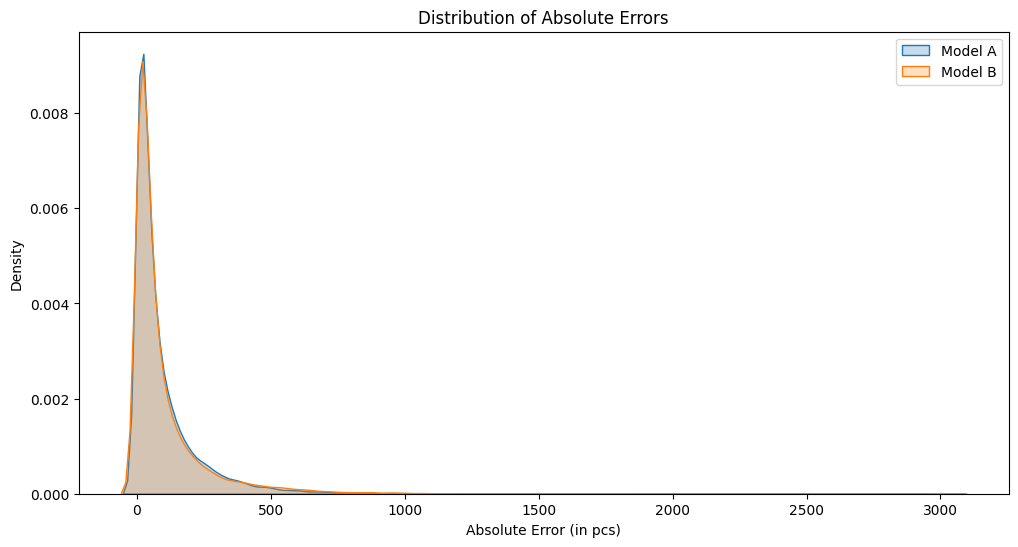

In [ ]:
merged_A['abs_error'] = merged_A['abs_error'].astype(float)
merged_B['abs_error'] = merged_B['abs_error'].astype(float)

# Now, let's attempt to visualize the distribution of errors
plt.figure(figsize=(12, 6))

try:
    sns.kdeplot(merged_A['abs_error'], label='Model A', fill=True)
    sns.kdeplot(merged_B['abs_error'], label='Model B', fill=True)

    plt.title('Distribution of Absolute Errors')
    plt.xlabel('Absolute Error (in pcs)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"An error occurred: {e}")

# Calculate mean absolute error by department and section for Model A
mae_by_department_A = merged_A_with_hierarchy.groupby('department_name')['abs_error'].mean().sort_values(ascending=False)
mae_by_section_A = merged_A_with_hierarchy.groupby('section_name')['abs_error'].mean().sort_values(ascending=False)

# Do the same for Model B
mae_by_department_B = merged_B_with_hierarchy.groupby('department_name')['abs_error'].mean().sort_values(ascending=False)
mae_by_section_B = merged_B_with_hierarchy.groupby('section_name')['abs_error'].mean().sort_values(ascending=False)

In [ ]:
# Correctly merging the error data with the article hierarchy for this analysis
merged_A_with_hierarchy = pd.merge(merged_A[['article_id', 'abs_error']], article_hierarchy, on="article_id", how="left")
merged_B_with_hierarchy = pd.merge(merged_B[['article_id', 'abs_error']], article_hierarchy, on="article_id", how="left")

# Recalculating mean absolute error by department and section for Model A
mae_by_department_A = merged_A_with_hierarchy.groupby('department_name')['abs_error'].mean().sort_values(ascending=False)
mae_by_section_A = merged_A_with_hierarchy.groupby('section_name')['abs_error'].mean().sort_values(ascending=False)

# Recalculating mean absolute error by department and section for Model B
mae_by_department_B = merged_B_with_hierarchy.groupby('department_name')['abs_error'].mean().sort_values(ascending=False)
mae_by_section_B = merged_B_with_hierarchy.groupby('section_name')['abs_error'].mean().sort_values(ascending=False)



print('model A by department: \n', mae_by_department_A.head(), mae_by_section_A.head())
print('\n\n\nmodel B by department: \n', mae_by_department_B.head(), mae_by_section_B.head())

model A by department: 
 department_name
Department_F    186.105363
Department_C    104.525802
Department_D    101.171794
Department_E     84.815238
Department_B     80.005353
Name: abs_error, dtype: float64 section_name
Section_01    100.266872
Section_03     96.586889
Section_02     90.297381
Name: abs_error, dtype: float64



model B by department: 
 department_name
Department_F    198.726151
Department_C    112.056769
Department_D    103.967438
Department_E     89.116835
Department_B     78.271776
Name: abs_error, dtype: float64 section_name
Section_01    106.188691
Section_03    103.783970
Section_02     94.094235
Name: abs_error, dtype: float64


The next step is to calculate the negative effects of overstocking. While we have seen from the previous two steps that model A is slightly better than model B and keeps enough items in stock better, this indicator might tell us more information.

In [ ]:
# Assume an arbitrary sale discount of 50% for end-of-season sales to clear overstock
sale_discount = 0.5

# Calculate initial potential revenue from lost sales due to stockouts
potential_revenue_loss = lost_sales_potential_A * price_and_cost.set_index('article_id').loc[merged_A['article_id']]['price_sek'].mean()

# Calculate the end-of-season overstock quantity
overstock_quantity_A = merged_A['order_suggestion_pcs'].sum() - merged_A['actual_sales_pcs'].sum()

# Calculate the financial cost of overstock
overstock_revenue_loss = overstock_quantity_A * price_and_cost['price_sek'].mean() * sale_discount

print('For model A, the potential revenue loss from stockouts is {} and the overstock quantity is {}. This leads to a revenue loss of {}'.format(potential_revenue_loss, overstock_quantity_A, overstock_revenue_loss))

# Calculate initial potential revenue from lost sales due to stockouts for Model B (using regular price)
potential_revenue_loss_B = lost_sales_potential_B * price_and_cost.set_index('article_id').loc[merged_B['article_id']]['price_sek'].mean()

# Calculate the end-of-season overstock quantity for Model B (assuming all unsold items are overstock)
overstock_quantity_B = merged_B['order_suggestion_pcs'].sum() - merged_B['actual_sales_pcs'].sum()

# Calculate the financial cost of overstock for Model B (revenue lost due to selling at a discount)
overstock_revenue_loss_B = overstock_quantity_B * price_and_cost['price_sek'].mean() * sale_discount

print('For model B, the potential revenue loss from stockouts is {} and the overstock quantity is {}. This leads to a revenue loss of {}'.format(potential_revenue_loss_B, overstock_quantity_B, overstock_revenue_loss_B))

For model A, the potential revenue loss from stockouts is 715.1897456224207 and the overstock quantity is 5809001. This leads to a revenue loss of 676717301.1307278
For model B, the potential revenue loss from stockouts is 29561.17615239339 and the overstock quantity is 4974510. This leads to a revenue loss of 579503598.2345014


- Lost Sales Revenue: Model B had a much higher potential revenue loss due to stockouts (SEK 29,561.18) compared to Model A (SEK 715.19), indicating Model B may not be as effective in avoiding stockouts.
- Overstock Quantity: Model A had a higher overstock quantity (5,809,001 pieces) compared to Model B (4,974,510 pieces), suggesting Model A might be more conservative in its ordering, leading to more overstock.
- Financial Cost of Overstock: The financial impact of overstock was also higher for Model A (SEK 676,717,301) compared to Model B (SEK 579,503,598), reflecting the higher overstock quantity.

Conclusion: Winner is model B
While Model A offers better sales predictions and might be more effective in minimizing lost sales revenue, it also leads to a higher financial and environmental cost due to overstock. Model B, despite its shortcomings in preventing stockouts, results in less overstock and associated costs. As a result, despite the fact that model B seems to be less accurate at predicting sales and leads to more stockouts, it is more environmentally friendly and results in less loss of revenue due to less overstocking.